<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
!pip install yfinance

In [85]:
!pip install pmdarima statsmodels scikit-learn

In [86]:
#!pip install --upgrade scikit-learn pmdarima

In [87]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# Load Data

In [88]:
start_date = datetime(2007, 3, 18)
end_date = datetime (2025, 3, 18)
ticker = 'BTC-USD'
df =yf.download(ticker, start=start_date, end=end_date)['Close']
df = df.rename(columns={ticker:'y'})
df = df.resample('ME').last()


[*********************100%***********************]  1 of 1 completed


In [89]:
df

Ticker,y
Date,
2014-09-30,386.944000
2014-10-31,338.321014
2014-11-30,378.046997
2014-12-31,320.192993
2015-01-31,217.464005
...,...
2024-11-30,96449.054688
2024-12-31,93429.203125
2025-01-31,102405.023438


<Axes: xlabel='Date'>

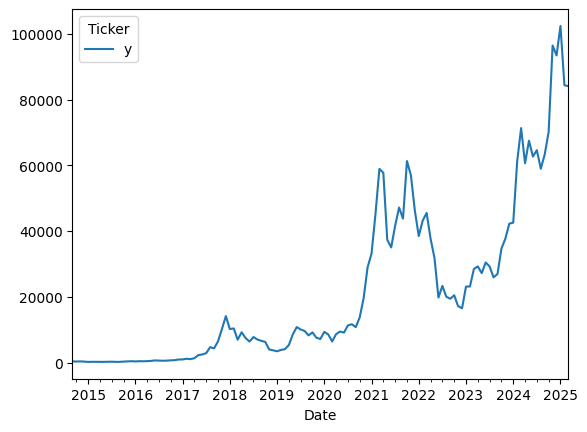

In [90]:
df.plot()

## Train / Test

In [91]:
size = int(len(df) * 0.75)
train, test = df[0:size], df[size:len(df)]
h = len(test)
print(train.shape)
print(test.shape)

(95, 1)
(32, 1)


In [92]:
train

Ticker,y
Date,
2014-09-30,386.944000
2014-10-31,338.321014
2014-11-30,378.046997
2014-12-31,320.192993
2015-01-31,217.464005
...,...
2022-03-31,45538.675781
2022-04-30,37714.875000
2022-05-31,31792.310547


# Analysis

<Axes: xlabel='Date'>

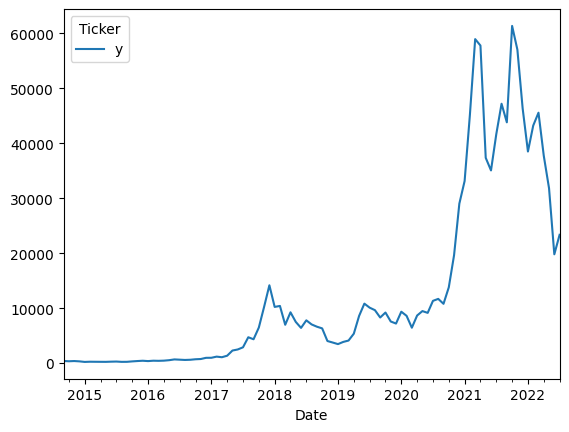

In [93]:
train.plot()

<Axes: xlabel='Date'>

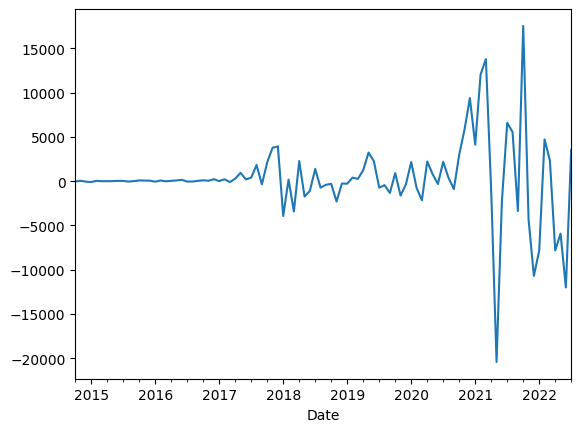

In [94]:
diff1 = train['y'].diff(1).dropna()
diff1.plot()

## Normalization

In [95]:
train_log = train.copy()
train_log['y']=np.log(train_log['y'])

In [96]:
train_log

Ticker,y
Date,
2014-09-30,5.958280
2014-10-31,5.823995
2014-11-30,5.935019
2014-12-31,5.768924
2015-01-31,5.382033
...,...
2022-03-31,10.726317
2022-04-30,10.537810
2022-05-31,10.366980


<Axes: xlabel='Date'>

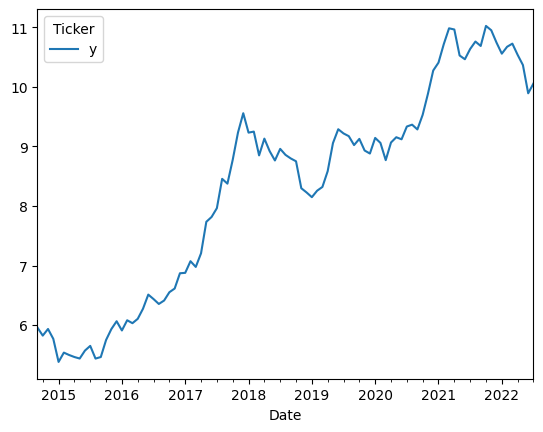

In [97]:
train_log.plot()

## Differentiation

In [98]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

### Série Original

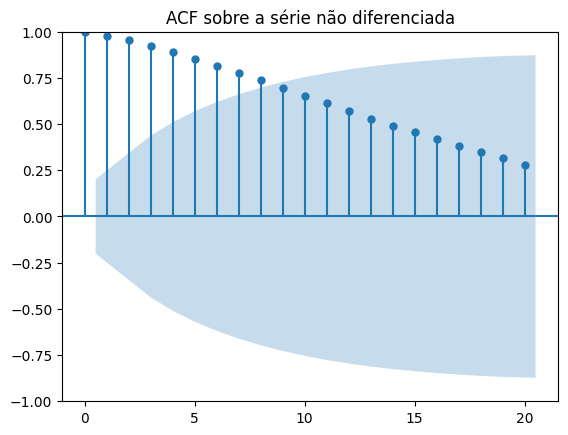

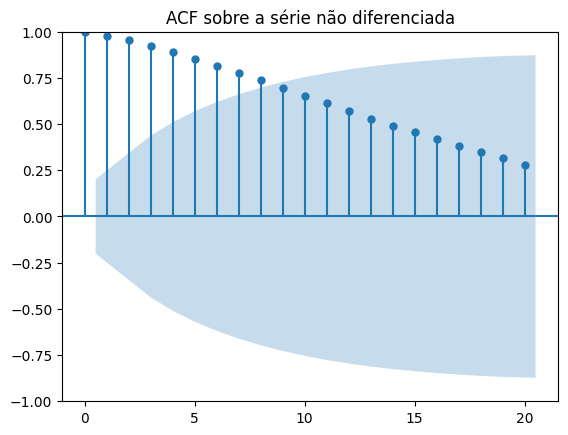

In [99]:
plot_acf(train_log, title='ACF sobre a série não diferenciada')

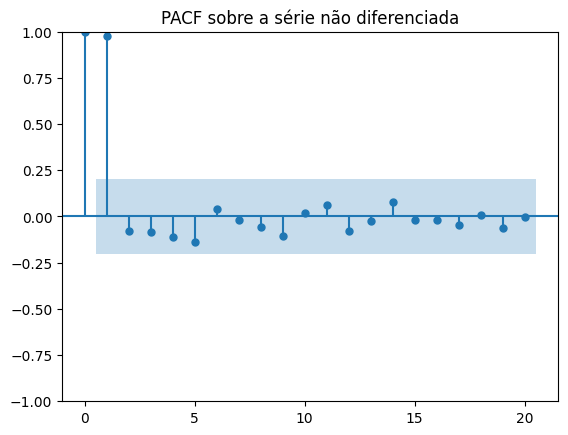

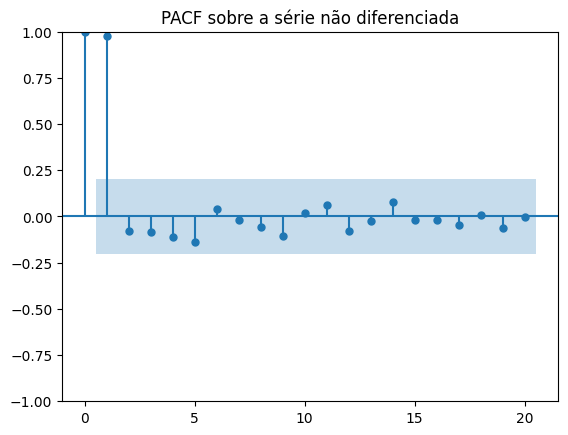

In [100]:
plot_pacf(train_log, title='PACF sobre a série não diferenciada')

### 1ª diff

In [101]:
diff1 = train_log['y'].diff(1).dropna()

<Axes: xlabel='Date'>

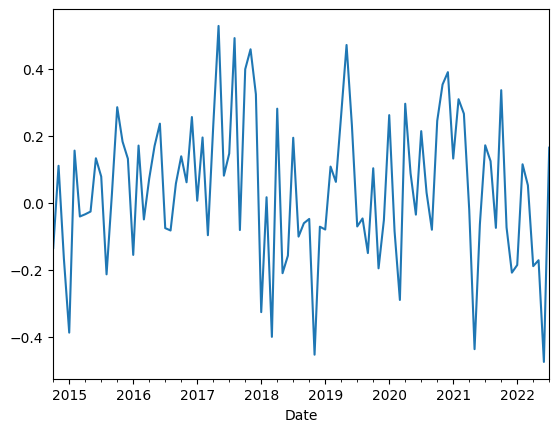

In [102]:
diff1.plot()

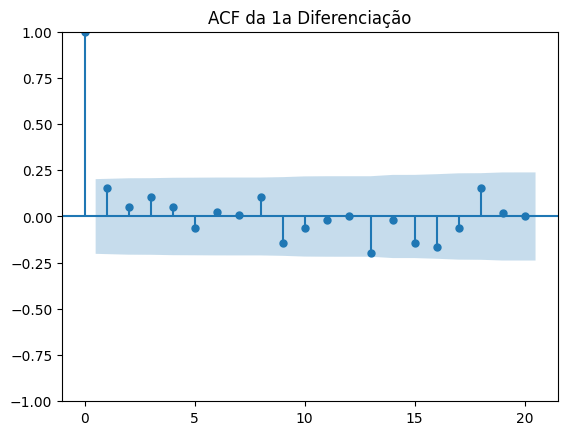

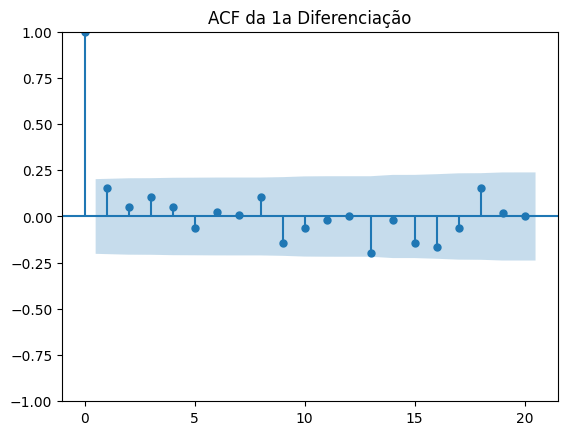

In [103]:
plot_acf(diff1, title='ACF da 1a Diferenciação')

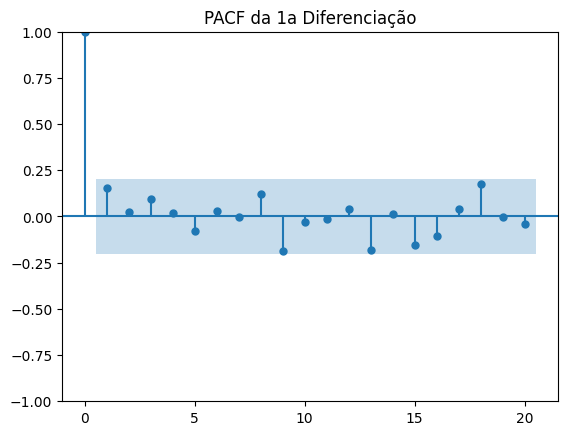

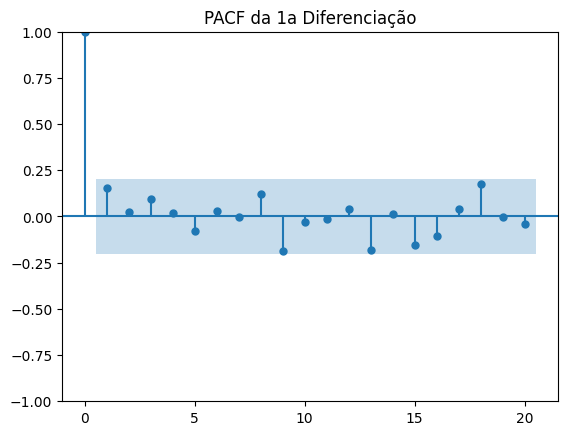

In [104]:
plot_pacf(diff1, title='PACF da 1a Diferenciação')

In [105]:
adf_test(diff1)

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.195105e+00
p-value                 7.485956e-13
# lags used             0.000000e+00
# observations          9.300000e+01
critical value (1%)    -3.502705e+00
critical value (5%)    -2.893158e+00
critical value (10%)   -2.583637e+00
Reject the null hypothesis
Data has no unit root and is stationary


### 2ª diff

In [106]:
diff2 = diff1.diff(1).dropna()


<Axes: xlabel='Date'>

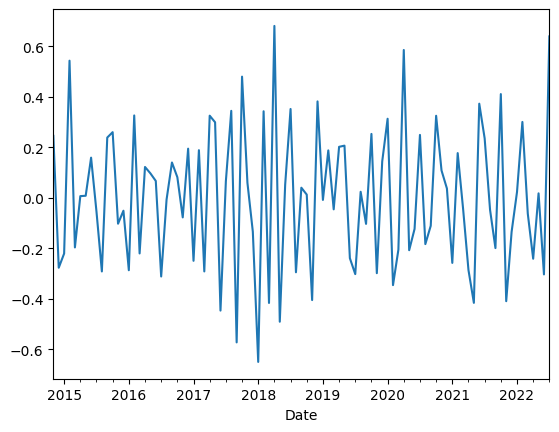

In [107]:
diff2.plot()

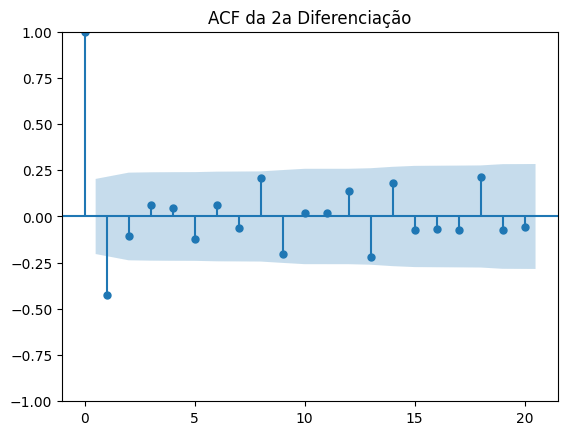

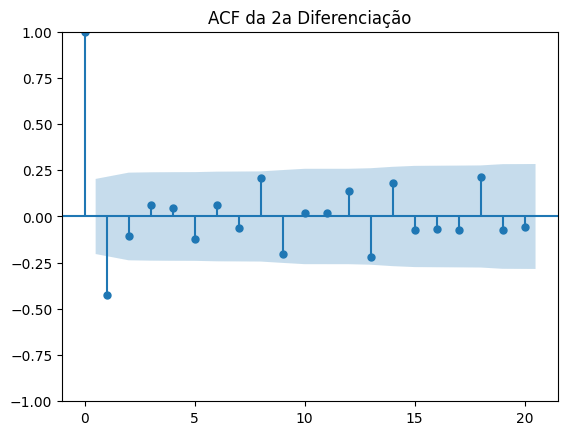

In [108]:
plot_acf(diff2, title='ACF da 2a Diferenciação')

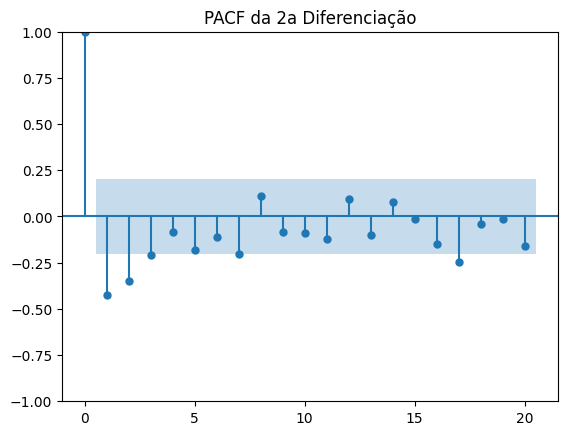

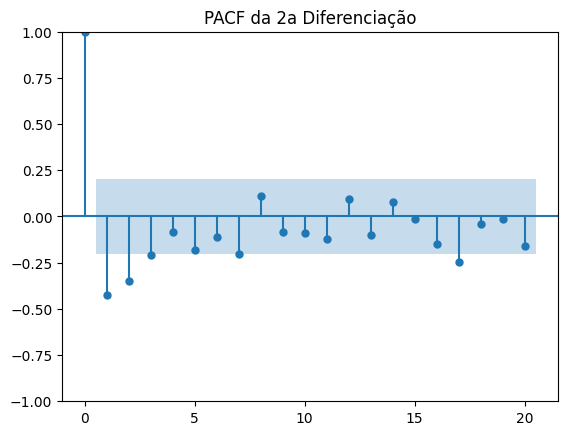

In [109]:
plot_pacf(diff2, title='PACF da 2a Diferenciação')

In [110]:
adf_test(diff2)

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.228852e+00
p-value                 5.010641e-08
# lags used             6.000000e+00
# observations          8.600000e+01
critical value (1%)    -3.508783e+00
critical value (5%)    -2.895784e+00
critical value (10%)   -2.585038e+00
Reject the null hypothesis
Data has no unit root and is stationary


## Conclusion
Tomando como base o procedimento definido em https://otexts.com/fpp3/arima-r.html, a análise dos gráficos sugere os seguintes hiperparâmetros:

In [132]:
p = 1
d = 0
q = 0

# Modelo AR

In [133]:
mod1 = AutoReg(train_log['y'], p, old_names=False)
res1 = mod1.fit()
print(res1.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   95
Model:                     AutoReg(1)   Log Likelihood                  11.209
Method:               Conditional MLE   S.D. of innovations              0.215
Date:                Thu, 27 Mar 2025   AIC                            -16.418
Time:                        23:25:51   BIC                             -8.788
Sample:                    10-31-2014   HQIC                           -13.336
                         - 07-31-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1399      0.106      1.316      0.188      -0.068       0.348
y.L1           0.9884      0.013     78.741      0.000       0.964       1.013
                                    Roots           

Bons modelos são obtidos minimizando o AIC ou BIC.

<Axes: xlabel='Date'>

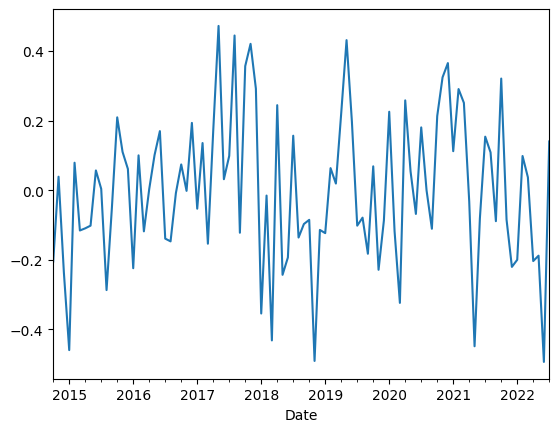

In [134]:
residuals = res1.resid
residuals.plot()

<Axes: ylabel='Density'>

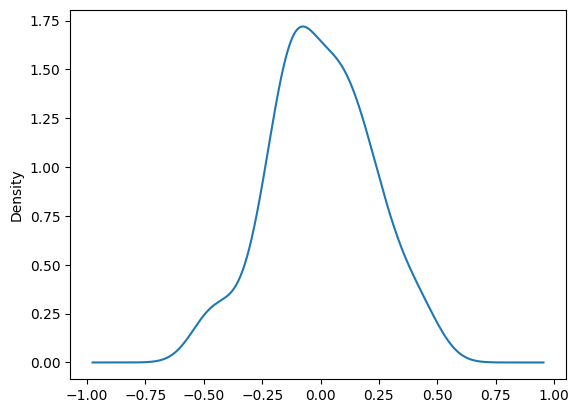

In [135]:
# density plot of residuals
residuals.plot(kind='kde')

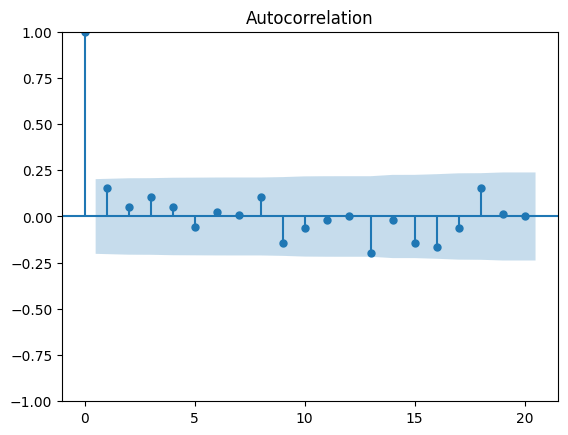

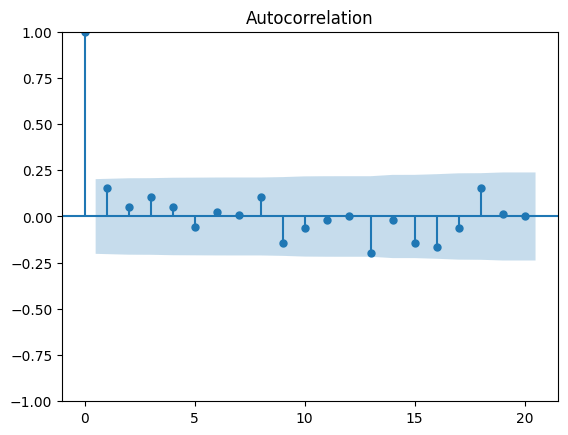

In [136]:
plot_acf(residuals)

In [137]:
adf_test(residuals)

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.196383e+00
p-value                 7.430012e-13
# lags used             0.000000e+00
# observations          9.300000e+01
critical value (1%)    -3.502705e+00
critical value (5%)    -2.893158e+00
critical value (10%)   -2.583637e+00
Reject the null hypothesis
Data has no unit root and is stationary


In [138]:
# This is the general format for obtaining predictions
start=len(train_log)
end=len(train_log)+h-1
ar_predictions = np.exp(res1.predict(start=start, end=end, dynamic=False).rename(f'AR({p}) Predictions'))

In [139]:
ar_predictions

,AR(1) Predictions
2022-08-31,23879.387222
2022-09-30,24427.963888
2022-10-31,24982.547490
2022-11-30,25543.056697
2022-12-31,26109.407909
2023-01-31,26681.515333
2023-02-28,27259.291059
2023-03-31,27842.645139
2023-04-30,28431.485660
2023-05-31,29025.718828


<Axes: xlabel='Date'>

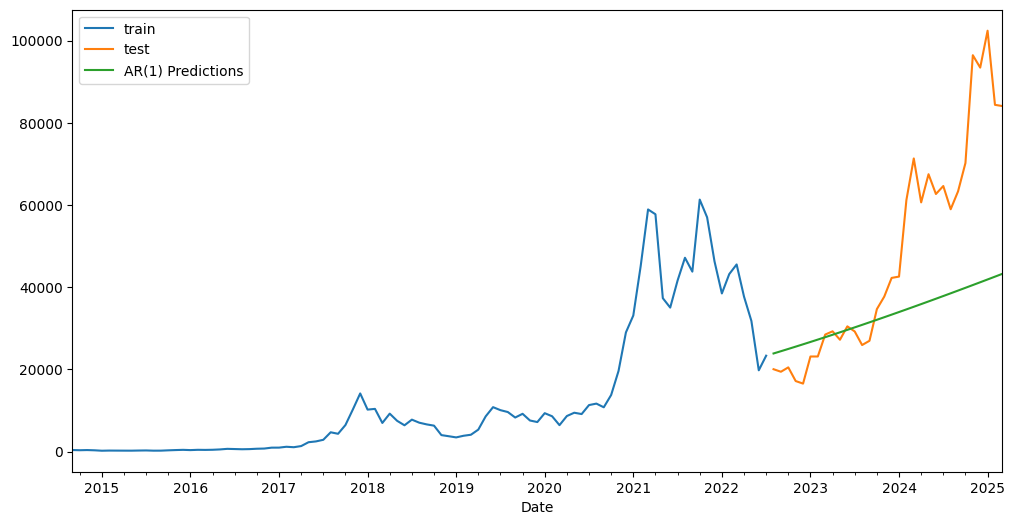

In [140]:
train['y'].plot(legend=True, label='train')
test['y'].plot(legend=True, label='test')
ar_predictions.plot(legend=True,figsize=(12,6))

In [141]:
def metrics(test, predictions):
  # Cálculo das métricas de avaliação
  mse = mean_squared_error(test['y'], predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test['y'], predictions)
  r2 = r2_score(test['y'], predictions)

  # Calcular MAPE (Mean Absolute Percentage Error)
  mape = np.mean(np.abs((test['y'] - predictions) / test['y'])) * 100

  # Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
  smape = np.mean(2 * np.abs(test['y'] - predictions) /
                (np.abs(test['y']) + np.abs(predictions))) * 100

  # Exibir as métricas
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R²: {r2}")
  print(f"MAPE: {mape}")
  print(f"SMAPE: {smape}")

metrics( test, ar_predictions)


MSE: 633983092.5755565
RMSE: 25179.02088198738
MAE: 17983.660809950718
R²: 0.04403346351433168
MAPE: 30.37312862711431
SMAPE: 35.86797388217672


# Modelo Arima

In [142]:
arima_model = ARIMA(train_log, order=(p,d,q))
fitted_arima_model = arima_model.fit()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   95
Model:                 ARIMA(1, 0, 0)   Log Likelihood                   6.936
Date:                Thu, 27 Mar 2025   AIC                             -7.872
Time:                        23:25:53   BIC                             -0.210
Sample:                    09-30-2014   HQIC                            -4.776
                         - 07-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0764      1.614      5.002      0.000       4.912      11.241
ar.L1          0.9936      0.014     72.504      0.000       0.967       1.021
sigma2         0.0483      0.008      6.347      0.0

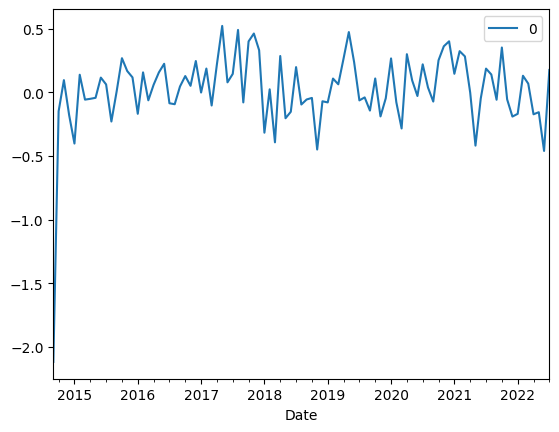

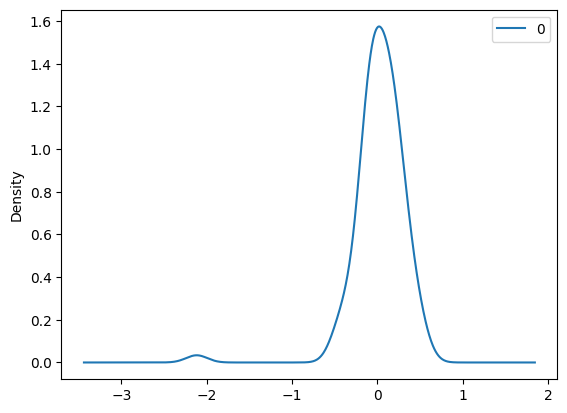

In [143]:

# summary of fit model
print(fitted_arima_model.summary())
# line plot of residuals
residuals = DataFrame(fitted_arima_model.resid)
residuals.plot()

# density plot of residuals
residuals.plot(kind='kde')

# summary stats of residuals
print(residuals.describe())

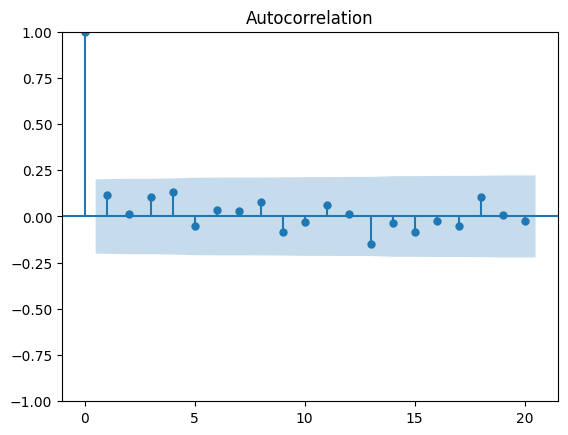

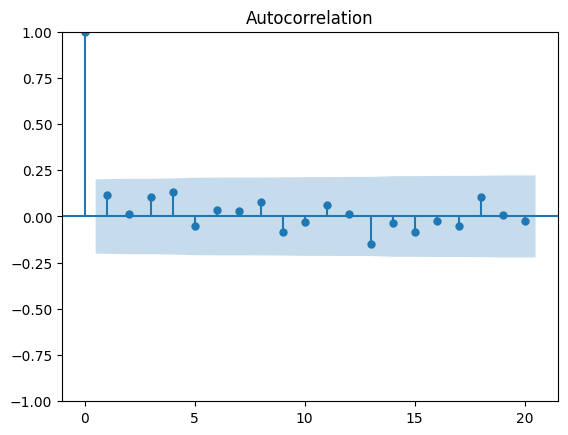

In [144]:
plot_acf(residuals)

In [145]:
adf_test(residuals)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.230329e+01
p-value                 7.367290e-23
# lags used             0.000000e+00
# observations          9.400000e+01
critical value (1%)    -3.501912e+00
critical value (5%)    -2.892815e+00
critical value (10%)   -2.583454e+00
Reject the null hypothesis
Data has no unit root and is stationary


In [125]:
history = train_log['y'].tolist()

arima_predictions = np.array([])
#walk-foward validation
#test_values = test['y'].tolist()
for t in range(h):
  arima_model = ARIMA(history, order=(p,d,q))
  # fit model
  fitted_arima_model = arima_model.fit()
  yhat = np.exp(fitted_arima_model.forecast()[0])
  arima_predictions = np.append(arima_predictions, yhat)
  obs = test['y'].iloc[t]
  history.append(np.log(obs))
  print(f'predicted={yhat}, expected={obs}')



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=25779.5507611012, expected=20049.763671875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=20156.31513036179, expected=19431.7890625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=21822.367372294804, expected=20495.7734375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=16402.552839286276, expected=17168.56640625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=15308.384056960698, expected=16547.49609375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=15356.138244932074, expected=23139.283203125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=23574.688825945508, expected=23147.353515625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=20723.271766977454, expected=28478.484375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=32559.384245098125, expected=29268.806640625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=32091.81990603332, expected=27219.658203125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=27136.271706307532, expected=30477.251953125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=34236.33552478354, expected=29230.111328125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=31983.509424363216, expected=25931.47265625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=29427.552614504122, expected=26967.916015625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=26667.99069591012, expected=34667.78125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=32294.779742169536, expected=37712.74609375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=37551.6561237554, expected=42265.1875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=43445.08740127351, expected=42582.60546875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=38814.9373258787, expected=61198.3828125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=64969.85274774015, expected=71333.6484375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=69441.01648066594, expected=60636.85546875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=67804.77396976591, expected=67491.4140625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=78237.82336532128, expected=62678.29296875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=64672.766956465864, expected=64619.25


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=63134.26896651097, expected=58969.8984375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=62295.15918277775, expected=63329.5


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=70948.9597231718, expected=70215.1875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=61911.14270108383, expected=96449.0546875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=95680.02131436768, expected=93429.203125


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=101507.87486701508, expected=102405.0234375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=103096.58974977127, expected=84373.0078125
predicted=78702.37758219507, expected=84075.6875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='ds'>

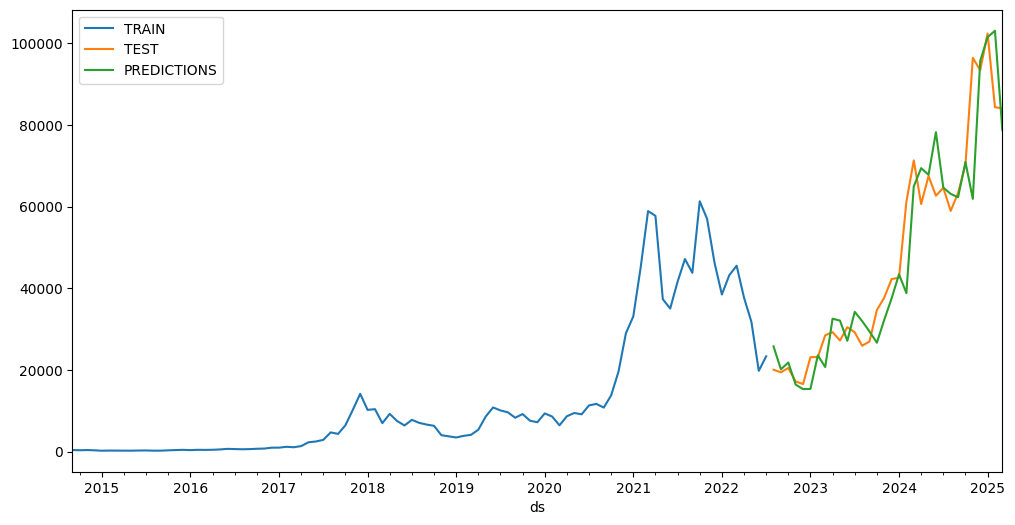

In [126]:
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':arima_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


In [127]:
metrics(test, arima_predictions)

MSE: 88946365.99139392
RMSE: 9431.138106898548
MAE: 5967.505516369069
R²: 0.8658800992872757
MAPE: 13.017428249026274
SMAPE: 13.55456818737224


In [128]:
fitted_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  126
Model:                ARIMA(9, 1, 13)   Log Likelihood                  34.159
Date:                Thu, 27 Mar 2025   AIC                            -22.318
Time:                        23:25:50   BIC                             42.733
Sample:                             0   HQIC                             4.108
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2356      0.520     -0.453      0.650      -1.254       0.783
ar.L2          0.1521      0.493      0.309      0.758      -0.814       1.118
ar.L3         -0.6540      0.344     -1.902      0.057      -1.328       0.020
ar.L4         -0.2511      0.403     -0.623      0.533      -1.041       0.539
ar.L5         -0.5396      0.310     -1.743      0.081      -1.147       0.067
ar.L6         -0.4850      0.400     -1.212      0.226      -1.269       0.299
ar.L7          0.1422      0.372      0.382      0.702      -0.587       0.871
ar.L8         -0.3507      0.343     -1.023      0.306      -1.023       0.321
ar.L9         -0.5330      0.295     -1.808      0.071      -1.111       0.045
ma.L1          0.4103      0.608      0.674      0.500      -0.782       1.603
ma.L2          0.0019      0.643      0.003      0.998      -1.258       1.262
ma.L3          0.7633      0.377      2.027      0.043       0.025       1.502
ma.L4          0.4247      0.460      0.924      0.355      -0.476       1.326
ma.L5          0.6993      0.626      1.117      0.264      -0.528       1.927
ma.L6          0.7559      0.451      1.674      0.094      -0.129       1.641
ma.L7          0.0158      0.492      0.032      0.974      -0.949       0.980
ma.L8          0.7239      0.438      1.652      0.098      -0.135       1.583
ma.L9          0.7249      0.501      1.447      0.148      -0.257       1.707
ma.L10         0.0551      0.231      0.239      0.811      -0.398       0.508
ma.L11         0.3325      0.165      2.018      0.044       0.010       0.655
ma.L12         0.2124      0.273      0.778      0.437      -0.323       0.748
ma.L13         0.0293      0.194      0.151      0.880      -0.351       0.410
sigma2         0.0325      0.010      3.231      0.001       0.013       0.052
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.49
Prob(Q):                              0.79   Prob(JB):                         0.11
Heteroskedasticity (H):               0.80   Skew:                            -0.40
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Modelo Exponential Smoothing

/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: xlabel='ds'>

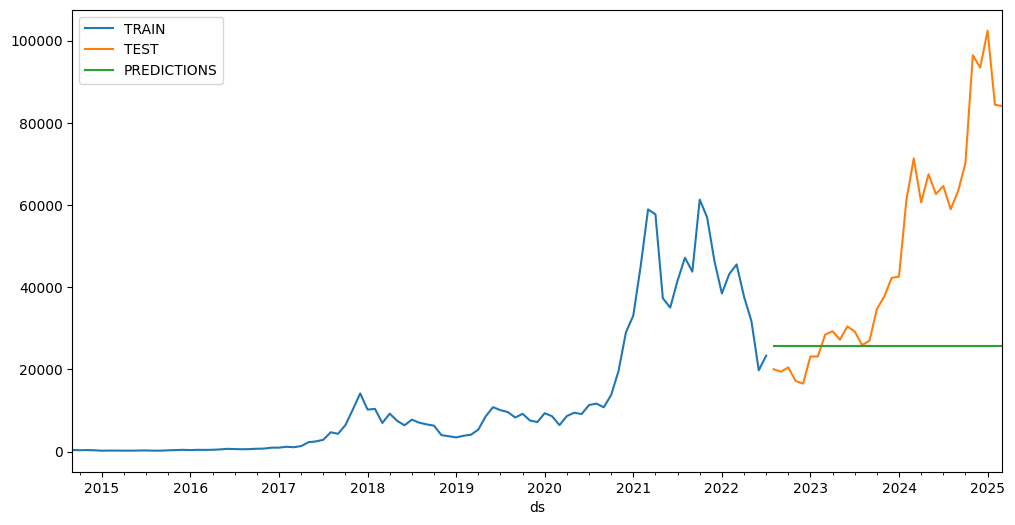

In [129]:
# Simple Exponential Smoothing (SES) for data without trends or seasonality
ses_model = SimpleExpSmoothing(train)
fitted_ses_model = ses_model.fit(smoothing_level=0.5)
ses_predictions = fitted_ses_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':ses_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo Holt

<Axes: xlabel='ds'>

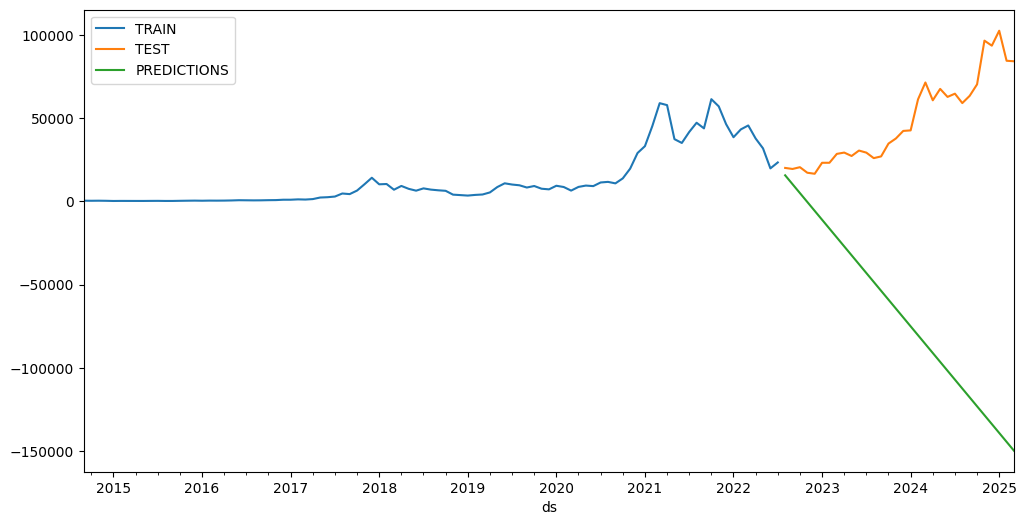

In [130]:
# Double exponential smoothing, also known as Holt's method, extends single exponential smoothing to capture trends in the data.

holt_model = ExponentialSmoothing(train, trend="add", seasonal=None)
fitted_holt_model = holt_model.fit(smoothing_level=0.5, smoothing_trend=0.5)
holt_predictions = fitted_holt_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':holt_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo Damped

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='ds'>

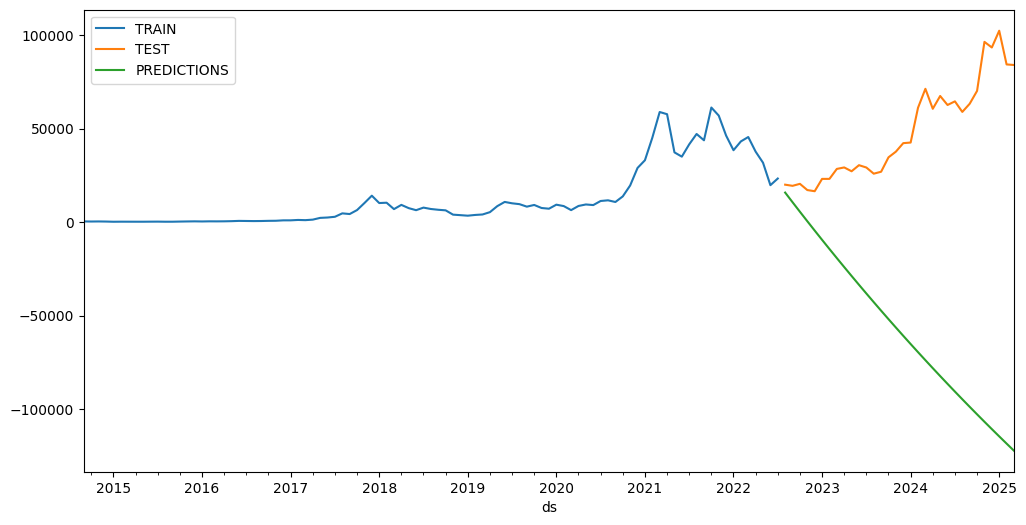

In [131]:
# The Damped Trend model is an extension of Holt’s linear method that introduces a damping parameter (ϕ),
# which gradually reduces the influence of the trend component over time

damped_model = ExponentialSmoothing(train, trend="add", seasonal=None, damped_trend=True)
fitted_damped_model = damped_model.fit(smoothing_level=0.5, smoothing_trend=0.5)
damped_predictions = fitted_damped_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':damped_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))
